In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir(globals()['_dh'][0])
os.chdir('..')
# print(os.path.abspath(os.curdir))

In [2]:
from src.torchwavenet import Wave
from src.torchdataset import RFMixtureDatasetBase
from omegaconf import OmegaConf
import torch
from torch.utils.data import DataLoader
import numpy as np

from torchsummary import summary

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

Using device:  cuda


In [4]:
soi_type = "QPSK"
interference_type = "CommSignal2"
dataset = RFMixtureDatasetBase(
    root_dir=f"npydataset/Dataset_{soi_type}_{interference_type}_Mixture")
loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [5]:
batch = next(iter(loader))
batch["sample_mix"].shape, batch["sample_soi"].shape, batch["sample_metadata"].shape

(torch.Size([1, 2, 40960]), torch.Size([1, 2, 40960]), torch.Size([1, 2]))

In [6]:
cfg = OmegaConf.load("src/configs/wavenet.yml")
model = Wave(cfg.model).to(device)
summary(model, input_size=batch["sample_mix"].shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1           [-1, 128, 40960]             384
            Conv1d-2           [-1, 256, 40960]          98,560
            Conv1d-3           [-1, 256, 40960]          33,024
     ResidualBlock-4  [[-1, 128, 40960], [-1, 128, 40960]]               0
            Conv1d-5           [-1, 256, 40960]          98,560
            Conv1d-6           [-1, 256, 40960]          33,024
     ResidualBlock-7  [[-1, 128, 40960], [-1, 128, 40960]]               0
            Conv1d-8           [-1, 256, 40960]          98,560
            Conv1d-9           [-1, 256, 40960]          33,024
    ResidualBlock-10  [[-1, 128, 40960], [-1, 128, 40960]]               0
           Conv1d-11           [-1, 256, 40960]          98,560
           Conv1d-12           [-1, 256, 40960]          33,024
    ResidualBlock-13  [[-1, 128, 40960], [-1, 128, 40960]]            

In [7]:
# load weights
loaded_model = torch.load(
    "torchmodels/dataset_qpsk_commsignal2_mixture_wavenet/weights-206000.pt")
# loaded_model = torch.load("torchmodels/dataset_qpsk_commsignal2_mixture_wavenet/weights.pt")
print(loaded_model.keys())
model.load_state_dict(loaded_model["model"])

dict_keys(['step', 'model', 'optimizer', 'cfg', 'scaler'])


<All keys matched successfully>

In [8]:
batch

{'sample_mix': tensor([[[-0.1068,  0.3362,  2.5965,  ...,  1.1558,  1.6059,  2.6087],
          [ 3.6352,  2.2412,  2.5167,  ...,  2.5189,  0.1930, -1.0683]]]),
 'sample_soi': tensor([[[ 0.4592,  0.5614,  0.6590,  ..., -0.7476, -0.6590, -0.5614],
          [ 0.4592,  0.5614,  0.6590,  ...,  0.5116,  0.4639,  0.4129]]]),
 'sample_metadata': tensor([[-24.3889, -24.6513]])}

In [9]:
model.eval()

sinr_all = []
soi_target = []
soi_no_mitigation = []
soi_est = []

for i, batch in enumerate(loader):
    # if i == 3:
    #     break
    sample_mix = batch["sample_mix"].to(device)

    sample_soi_hat = model(sample_mix)

    soi_target.extend(batch["sample_soi"].numpy())
    sinr_all.extend(batch["sample_metadata"].numpy())
    soi_no_mitigation.extend(sample_mix.cpu().detach().numpy())
    soi_est.extend(sample_soi_hat.cpu().detach().numpy())

soi_target = np.array(soi_target)
sinr_all = np.array(sinr_all)
soi_no_mitigation = np.array(soi_no_mitigation)
soi_est = np.array(soi_est)
soi_target.shape, sinr_all.shape, soi_no_mitigation.shape, soi_est.shape

((1000, 2, 40960), (1000, 2), (1000, 2, 40960), (1000, 2, 40960))

In [10]:
import rfcutils

2024-03-30 19:19:37.209145: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-30 19:19:37.209202: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-30 19:19:37.210127: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-30 19:19:37.215298: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-30 19:19:39.419313: I tensorflow/core/common_

In [11]:
# we have a stacked tensor along the second axis for the real and imaginary parts
soi_no_mitigation = soi_no_mitigation[:,
                                      0, :] + 1j * soi_no_mitigation[:, 1, :]
soi_target = soi_target[:, 0, :] + 1j * soi_target[:, 1, :]
soi_est = soi_est[:, 0, :] + 1j * soi_est[:, 1, :]
print(soi_target.shape, soi_no_mitigation.shape, soi_est.shape)
bit_demod, _ = rfcutils.qpsk_matched_filter_demod(soi_target)
bit_no_mitigation, _ = rfcutils.qpsk_matched_filter_demod(soi_no_mitigation)
bit_est, _ = rfcutils.qpsk_matched_filter_demod(soi_est)

(1000, 40960) (1000, 40960) (1000, 40960)


2024-03-30 19:19:39.960816: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-30 19:19:40.323392: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-03-30 19:19:40.383543: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [12]:
# evaluate the bit error rate
ber_all_examples_no_mitigation = np.mean(
    bit_no_mitigation != bit_demod, axis=-1).astype(np.float32)
ber_all_examples_wavenet = np.mean(
    bit_est != bit_demod, axis=-1).astype(np.float32)
print(f"{'Examples':<10} {'BER (No Mitigation)':<20} {'BER (WaveNet)':<20} {'SINR':<10}")
for i, (ber1, ber2) in enumerate(zip(ber_all_examples_no_mitigation, ber_all_examples_wavenet)):
    if ber1 <= 1e-2 or ber2 <= 1e-2:  # only print if the BER is significant
        print(f"{i + 1:<10} {ber1:<20.10f} {ber2:<20.10f} {sinr_all[i][1]:<10.2f}")

Examples   BER (No Mitigation)  BER (WaveNet)        SINR      
1          0.0515624993         0.0000000000         -5.25     
2          0.2988281250         0.0000000000         -19.42    
3          0.2585937381         0.0001953125         -17.31    
4          0.2705078125         0.0007812500         -18.33    
5          0.3300781250         0.0017578125         -21.21    
6          0.3246093690         0.0029296875         -21.98    
8          0.3822265565         0.0062500001         -25.32    
9          0.2300781310         0.0044921874         -13.99    
10         0.0000000000         0.0000000000         2.72      
11         0.0423828140         0.0000000000         -4.37     
12         0.0992187485         0.0000000000         -8.54     
13         0.1685546935         0.0000000000         -12.39    
15         0.3148437440         0.0017578125         -20.41    
16         0.0005859375         0.0000000000         -0.84     
17         0.0000000000         0.000000

Text(0, 0.5, 'BER')

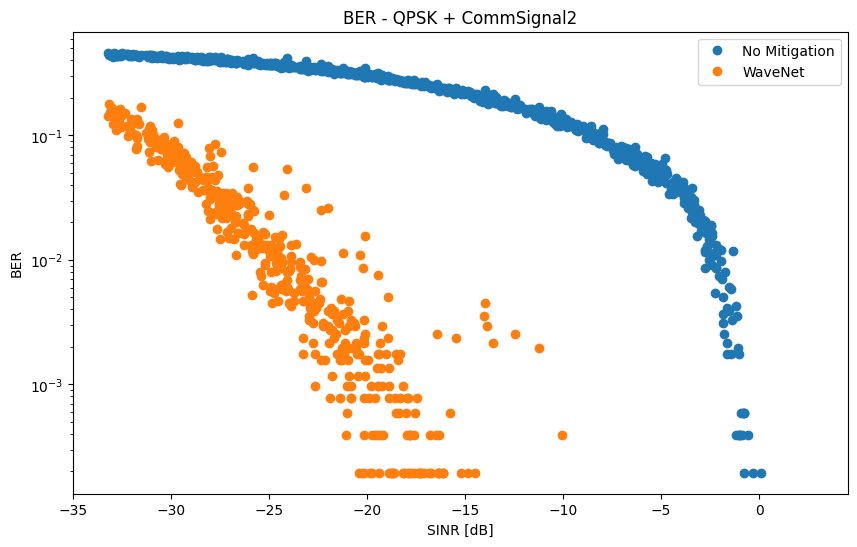

In [30]:
import  matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.semilogy(sinr_all[:, 1], ber_all_examples_no_mitigation, 'o', label="No Mitigation")
plt.semilogy(sinr_all[:, 1], ber_all_examples_wavenet, 'o', label="WaveNet")
plt.legend()
plt.title(f"BER - {soi_type} + {interference_type}")
plt.xlabel("SINR [dB]")
plt.ylabel("BER")
